# Differentiable bitonic sort

[Bitonic sorts](https://en.wikipedia.org/wiki/Bitonic_sorter) allow creation of sorting networks with a sequence of fixed conditional swapping operations executed in parallel. A sorting network implements  a map from $\mathbb{R}^n \rightarrow \mathbb{R}^n$, where $n=2^k$ (sorting networks for non-power-of-2 sizes are possible but not trickier).

<img src="BitonicSort1.svg.png">

*[Image: from Wikipedia, by user Bitonic, CC0](https://en.wikipedia.org/wiki/Bitonic_sorter#/media/File:BitonicSort1.svg)*

The sorting network for $n=2^k$ elements has $\frac{k(k-1)}{2}$ "layers" where parallel compare-and-swap operations are used to rearrange a $k$ element vector into sorted order.

### Differentiable compare-and-swap

If we define the `softmax(a,b)` function (not the traditional "softmax" used for classification, but properly `logsumexp(a,b)`) as the continuous approximation to the `max(a,b)` function:

$$\text{softmax}(a,b) = \log(e^a + e^b) \approx \max(a,b).$$

We can then fairly obviously write `softmin(a,b)` as:

$$\text{softmin}(a,b) = -\log(e^{-a} + e^{-b}) \approx \min(a,b).$$ More numerically stably we can write: 

$$\text{softmin}(a,b) = a + b - \text{softmax}(a,b).$$

These functions aren't equal to max and min, but are relatively close for numbers in some range, and differentiable. Note that we now have a differentiable compare-and-swap operation:

$$\text{softcswap}(a,b) = [\text{softmin}(a,b), \text{softmin}(a,b)]$$

#### Smoothmax
Alternatively, we can use [smoothmax](https://en.wikipedia.org/wiki/Smooth_maximum):

$$\text{smoothmax}(a,b) = \frac{a (e^{\alpha a}) + b (e^{\alpha b})}{e^{\alpha a}+e^{\alpha b}}  \approx \max(a,b).$$  This has an adjustable smoothness parameter $\alpha$, with exact maximum as $\alpha \rightarrow \infty$ and pure averaging as $\alpha \rightarrow 0$.

## Differentiable sorting

For each layer in the sorting network, we can split all of the pairwise comparison-and-swaps into left-hand and right-hand sides which can be done simultaneously. We can select the relevant elements of the vector as a multiply with a binary matrix.

For each layer, we can derive two binary matrices $L \in \mathbb{R}^{n \times \frac{n}{2}}$ and $R \in \mathbb{R}^{n \times \frac{n}{2}}$ which select the elements to be compared for the left and right hands respectively. This will result in the comparison between two $\frac{n}{2}$ length vectors. We can also derive two matrices $L' \in \mathbb{R}^{\frac{n}{2} \times n}$ and $R' \in \mathbb{R}^{\frac{n}{2} \times n}$ which put the results of the compare-and-swap operation back into the right positions.

Then, each layer $i$ of the sorting process is just:
$${\bf x}_{i+1} = L'_i[\text{softmin}(L_i{\bf x_i}, R_i{\bf x_i})] + R'_i[\text{softmax}(L_i{\bf x_i}, R_i{\bf x_i})]$$
$$ = L'_i\left(-\log\left(e^{-L_i{\bf x}_i} + e^{-R_i{\bf x}_i}\right)\right) +  R'_i\left(\log\left(e^{L_i{\bf x}_i} + e^{R_i{\bf x}_i}\right)\right)$$
which is differentiable (though not very numerically stable -- the usable range of elements $x$ is quite limited in single float precision).

All that remains is to compute the matrices $L_i, R_i, L'_i, R'_i$ for each of the layers of the network, which are fixed for a given $n$. 

### Indexed form
The matrices just implement permuations, so they can be replaced by reindexing, which requires only $2n$ indexing operations per layer, instead of $2 n \times n$ matrix multiplies. See the **Indexed form** section below.

## Example

To sort four elements, we have a network like:

    0  1  2  3  
    ┕>>┙  │  │  
    │  │  ┕<<┙  
    ┕>>>>>┙  │  
    │  │  │  │  
    ┕>>┙  │  │  
    │  │  ┕>>┙  
    
This is equivalent to: 

    x[0], x[1] = cswap(x[0], x[1])
    x[3], x[2] = cswap(x[2], x[3])
    x[0], x[2] = cswap(x[0], x[2])
    x[0], x[1] = cswap(x[0], x[1])
    x[2], x[3] = cswap(x[2], x[3])
    
where `cswap(a,b) = (min(a,b), max(a,b))`

Replacing the indexing with matrix multiplies and `cswap` with a `softcswap = (softmin(a,b), softmax(a,b))` we then have the differentiable form.



# Test functions

In [2]:
from bitonic_tests import bitonic_network, pretty_bitonic_network

def neat_vec(n):
    # print a vector neatly    
    return "\t".join([f"{x:6.2f}" for x in n])

# the comparisons should match the diagram at the top of the notebook
# each line represents one pair of matrix multiplies
bitonic_network(16)

 0>1	 2<3	 4>5	 6<7	 8>9	10<11	12>13	14<15	
----------------------------------------------------------------
 0>2	 1>3	 4<6	 5<7	 8>10	 9>11	12<14	13<15	
 0>1	 2>3	 4<5	 6<7	 8>9	10>11	12<13	14<15	
----------------------------------------------------------------
 0>4	 1>5	 2>6	 3>7	 8<12	 9<13	10<14	11<15	
 0>2	 1>3	 4>6	 5>7	 8<10	 9<11	12<14	13<15	
 0>1	 2>3	 4>5	 6>7	 8<9	10<11	12<13	14<15	
----------------------------------------------------------------
 0>8	 1>9	 2>10	 3>11	 4>12	 5>13	 6>14	 7>15	
 0>4	 1>5	 2>6	 3>7	 8>12	 9>13	10>14	11>15	
 0>2	 1>3	 4>6	 5>7	 8>10	 9>11	12>14	13>15	
 0>1	 2>3	 4>5	 6>7	 8>9	10>11	12>13	14>15	
----------------------------------------------------------------


In [3]:
# print the sorting network. The wires "going over" represent where the larger of the two values should go in each exchange.
pretty_bitonic_network(8)

 0  1  2  3  4  5  6  7 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╰──╮  │  │  │  │ 
 │  │  │  │  ╭──╯  │  │ 
 │  │  │  │  │  │  ╰──╮ 
 ╭─────╯  │  │  │  │  │ 
 │  ╭─────╯  │  │  │  │ 
 │  │  │  │  ╰─────╮  │ 
 │  │  │  │  │  ╰─────╮ 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╭──╯  │  │  │  │ 
 │  │  │  │  ╰──╮  │  │ 
 │  │  │  │  │  │  ╰──╮ 
 ╭───────────╯  │  │  │ 
 │  ╭───────────╯  │  │ 
 │  │  ╭───────────╯  │ 
 │  │  │  ╭───────────╯ 
 ╭─────╯  │  │  │  │  │ 
 │  ╭─────╯  │  │  │  │ 
 │  │  │  │  ╭─────╯  │ 
 │  │  │  │  │  ╭─────╯ 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╭──╯  │  │  │  │ 
 │  │  │  │  ╭──╯  │  │ 
 │  │  │  │  │  │  ╭──╯ 


# Vectorised functions

In [11]:
# Test sorting
import autograd.numpy as np # we can use plain numpy as well (but can't take grad!)
np.set_printoptions(precision=2, suppress=2)

from differentiable_sorting import bitonic_matrices, diff_sort, diff_argsort
from differentiable_sorting import softmax, smoothmax, softmax_smooth

## Testing sorting network
First, test bitonic sorting with exact (non-differentiable) maximum; this should work exactly as regular sorting does.

In [5]:


matrices = bitonic_matrices(8)

for i in range(5):
    # these should all be in sorted order
    test = np.random.randint(0, 200, 8)
    sortd = diff_sort(matrices, test, softmax=np.maximum)
    assert(np.allclose(sortd, np.sort(test))) # check sorting matches expected
    print(neat_vec(sortd))
    

  3.00	  9.00	 43.00	 75.00	116.00	161.00	164.00	189.00
 34.00	 65.00	 98.00	126.00	131.00	160.00	170.00	190.00
 19.00	 59.00	 78.00	 86.00	 99.00	132.00	146.00	147.00
 34.00	 44.00	 57.00	 86.00	110.00	159.00	170.00	175.00
  2.00	 39.00	 79.00	118.00	127.00	144.00	148.00	149.00


## Differentiable sorting test
Now we can replace `np.maximum` with `softmax` or `smoothmax`. This is approximately the same, *for reasonable values of the input* (typically ~1-300).

In [6]:
# Differentiable sorting 

matrices = bitonic_matrices(8) 

for i in range(5):
    # note the range here is chosen to work well: small values will not work well! 
    test = np.random.randint(-200,200,8)
    print("Softmax sorting   ", neat_vec(diff_sort(matrices, test, softmax=softmax)))
    print("Smoothmax sorting ", neat_vec(diff_sort(matrices, test, softmax=smoothmax)))
    print("Exact sorting     ", neat_vec(diff_sort(matrices, test, softmax=np.maximum)))
    
    print()

Softmax sorting    -169.00	-99.00	-53.00	-34.00	 20.00	 28.00	136.00	144.00
Smoothmax sorting  -169.00	-99.00	-53.00	-34.00	 20.00	 28.00	136.00	144.00
Exact sorting      -169.00	-99.00	-53.00	-34.00	 20.00	 28.00	136.00	144.00

Softmax sorting    -85.00	-27.00	 78.69	 80.31	126.00	151.00	161.31	162.69
Smoothmax sorting  -85.00	-27.00	 79.27	 79.73	126.00	151.00	162.00	162.00
Exact sorting      -85.00	-27.00	 79.00	 80.00	126.00	151.00	162.00	162.00

Softmax sorting    -188.00	-171.00	-101.23	-98.77	 35.00	 97.00	104.00	139.00
Smoothmax sorting  -188.00	-171.00	-100.49	-99.51	 35.00	 97.01	103.99	139.00
Exact sorting      -188.00	-171.00	-101.00	-99.00	 35.00	 97.00	104.00	139.00

Softmax sorting    -160.00	-56.00	 -9.00	 -1.31	  0.31	107.00	156.00	197.00
Smoothmax sorting  -160.00	-56.00	 -9.00	 -0.73	 -0.27	107.00	156.00	197.00
Exact sorting      -160.00	-56.00	 -9.00	 -1.00	  0.00	107.00	156.00	197.00

Softmax sorting    -200.09	-196.91	-139.02	-133.98	-121.00	 13.00	102.00	188.00
S

### Positive-only sorting
Slightly better accuracy can be achieved with normalised softmax *if* all elements are strictly positive:

In [7]:
for i in range(5):
    
    # softmax works less well in this range
    test = np.random.randint(1,8,8)
    print("Softmax sorting   ", neat_vec(diff_sort(matrices, test, softmax=softmax)))
    print("+Softmax sorting  ", neat_vec(diff_sort(matrices, test, softmax=lambda a,b: softmax(a,b,normalize=1))))
    print("Exact sorting     ", neat_vec(diff_sort(matrices, test, softmax=np.maximum)))
    
    print()

Softmax sorting     -0.06	  1.48	  1.82	  3.21	  2.86	  4.25	  4.51	  5.93
+Softmax sorting     0.36	  1.40	  1.79	  3.09	  2.83	  4.19	  4.46	  5.88
Exact sorting        1.00	  2.00	  3.00	  3.00	  3.00	  4.00	  4.00	  4.00

Softmax sorting      0.38	  1.90	  2.67	  4.11	  4.38	  5.88	  6.56	  8.12
+Softmax sorting     0.61	  1.81	  2.63	  4.05	  4.36	  5.87	  6.55	  8.12
Exact sorting        1.00	  2.00	  3.00	  4.00	  5.00	  5.00	  7.00	  7.00

Softmax sorting      1.26	  2.71	  3.01	  4.40	  4.16	  5.55	  6.21	  7.71
+Softmax sorting     1.38	  2.69	  3.00	  4.36	  4.15	  5.53	  6.20	  7.70
Exact sorting        3.00	  3.00	  4.00	  4.00	  4.00	  4.00	  6.00	  7.00

Softmax sorting      1.05	  2.44	  3.46	  4.96	  5.16	  6.55	  6.91	  8.46
+Softmax sorting     1.17	  2.38	  3.45	  4.94	  5.16	  6.54	  6.91	  8.46
Exact sorting        2.00	  2.00	  4.00	  5.00	  6.00	  6.00	  7.00	  7.00

Softmax sorting     -0.32	  1.39	  1.90	  3.29	  3.40	  4.84	  5.99	  7.51
+Softmax sorting     

## Sorting complex numbers
The softmax/smoothmax functions are analytic as well as differentiable, so 
we can also "sort" complex numbers. This approximately sorts them by the real part with smoothmax. This isn't a very useful operation.

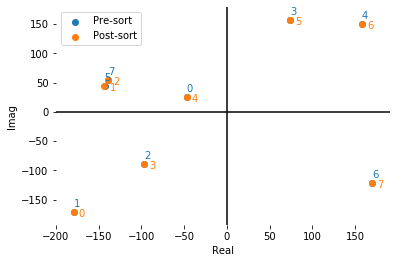

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


test = np.random.randint(-200,200,8) + 1j * np.random.randint(-200, 200, 8)
fig, ax = plt.subplots()

def label_complex(zs, color, xyoffset, label):
    ax.scatter(np.real(zs), np.imag(zs), c=color, label=label)    
    for i, z in enumerate(zs):
        ax.annotate(str(i), (np.real(z), np.imag(z)), color=color, textcoords="offset points", xytext=xyoffset)

        
label_complex(test, 'C0', (0,5), label="Pre-sort")

smooth_sorted = diff_sort(matrices, test, softmax=smoothmax)
label_complex(smooth_sorted, 'C1', (5, -5), "Post-sort")
ax.axhline(0, c='k')
ax.axvline(0, c='k')
ax.set_xlabel("Real")
ax.set_ylabel("Imag")
ax.set_frame_on(False)
ax.legend()



# Relaxed sorting
We can define a slighly modified function which interpolates between `softmax(a,b)` and `mean(a,b)`. The result is a sorting function that can be relaxed from sorting to averaging. The $\alpha$ parameter of `smoothmax` also allows relaxation to the mean, though with different scaling.

In [25]:

# Differentiable smoothed sorting 
test = np.random.randint(-200,200,8)

print("Exact sorting          ", neat_vec(diff_sort(matrices, test, np.maximum)))
print()

for smooth in np.linspace(0, 1, 5):    
    print(f"Softmax.   smooth={smooth:.2f} ", neat_vec(diff_sort(matrices, test, lambda a,b:softmax_smooth(a,b,smooth=smooth))))
    # smoothmax's alpha is the inverse of diff_bisort_smooth
    print(f"Smoothmax. α={1-smooth:.2f}      ", neat_vec(diff_sort(matrices, test, lambda a,b:smoothmax(a,b, alpha=1-smooth))))
    print()
    
print(f"Mean {np.mean(test):.2f}")
print()

Exact sorting           -180.00	-163.00	-33.00	-28.00	 11.00	 34.00	 66.00	 77.00

Softmax.   smooth=0.00  -180.00	-163.00	-33.01	-27.99	 11.00	 34.00	 66.00	 77.00
Smoothmax. α=1.00       -180.00	-163.00	-32.93	-28.07	 11.00	 34.00	 66.00	 77.00

Softmax.   smooth=0.25  -95.06	-90.72	-29.95	-23.05	 -6.50	  4.06	 10.91	 14.31
Smoothmax. α=0.75       -180.00	-163.00	-32.76	-28.24	 11.00	 34.00	 66.00	 77.00

Softmax.   smooth=0.50  -53.88	-52.63	-38.50	-34.86	-10.03	 -9.45	 -8.64	 -8.00
Smoothmax. α=0.50       -179.99	-163.01	-32.17	-28.83	 11.00	 34.00	 66.04	 76.96

Softmax.   smooth=0.75  -36.16	-35.88	-35.38	-35.09	-18.67	-18.40	-18.34	-18.07
Smoothmax. α=0.25       -179.50	-163.50	-30.96	-30.04	 11.07	 33.94	 66.65	 76.34

Softmax.   smooth=1.00  -27.00	-27.00	-27.00	-27.00	-27.00	-27.00	-27.00	-27.00
Smoothmax. α=0.00       -27.00	-27.00	-27.00	-27.00	-27.00	-27.00	-27.00	-27.00

Mean -27.00



## Derivatives of the sorting process
Now we can take the derivatives of the sorting networks.

In [13]:
from autograd import jacobian

matrices = bitonic_matrices(8)
test = np.random.randint(-200,200,8)
# show that we can take the derivative
jac_sort = jacobian(diff_sort, argnum=1)
jac_sort(matrices, test, softmax=lambda a,b:softmax_smooth(a,b,0.05)) # slight relaxation

array([[0.02, 0.02, 0.02, 0.86, 0.02, 0.02, 0.02, 0.  ],
       [0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.86, 0.02],
       [0.86, 0.02, 0.02, 0.02, 0.02, 0.  , 0.02, 0.02],
       [0.02, 0.02, 0.01, 0.02, 0.84, 0.02, 0.02, 0.03],
       [0.02, 0.31, 0.52, 0.02, 0.01, 0.03, 0.02, 0.06],
       [0.02, 0.49, 0.3 , 0.02, 0.03, 0.11, 0.01, 0.03],
       [0.02, 0.05, 0.05, 0.01, 0.03, 0.26, 0.02, 0.56],
       [0.01, 0.08, 0.05, 0.02, 0.03, 0.53, 0.02, 0.27]])

In [14]:
# the same, but using smoothmax
print(neat_vec(diff_sort(matrices, test, smoothmax)))
jac_sort(matrices, test,  lambda a,b:smoothmax(a,b,alpha=0.5))

-164.00	-136.00	-87.00	  4.00	 13.40	 13.40	 13.74	 15.45


array([[ 0.  , -0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.  ],
       [-0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  1.  , -0.  ],
       [ 1.  , -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  ],
       [-0.  , -0.03, -0.01,  0.  ,  1.09, -0.01,  0.  , -0.04],
       [-0.  ,  0.38,  0.3 ,  0.  , -0.03,  0.01,  0.  ,  0.34],
       [-0.  ,  0.47,  0.29,  0.  , -0.03,  0.02,  0.  ,  0.25],
       [-0.  ,  0.12,  0.33,  0.  , -0.02,  0.17, -0.  ,  0.39],
       [-0.  ,  0.06,  0.09,  0.  , -0.01,  0.81, -0.  ,  0.06]])

### Indexed form
Rather than using matrix multiplies, we can instead just generate the permutation indices and reindex the vectors (assuming the backend supports array indexing).

This requires only 2n indexing operations at each layer instead of 2 n x n matrix multiplies.

In [324]:
from differentiable_sorting import bitonic_indices, diff_sort_indexed
test = np.random.randint(-200,200,8)
indices = bitonic_indices(8)

print("Exact sorting      ", neat_vec(diff_sort(matrices, test, np.maximum)))
print(f"Indexed           ", neat_vec(diff_sort_indexed(indices, test, smoothmax)))


Exact sorting       -170.00	-155.00	-155.00	 -8.00	 11.00	 55.00	 57.00	141.00
Indexed            -170.00	-155.00	-155.00	 -8.00	 11.00	 55.51	 56.49	141.00


## Differentiable ranking / argsort
We can use a differentiable similarity measure between the input (unsorted) and output (sorted) of the sorting network, e.g. using an RBF kernel. We can use this to generate a normalised similarity matrix and apply this to a vector `[1, 2, 3, ..., n]`. This gives a differentiable ranking function.

As `sigma`, the RBF width goes to infinity, the result converges to giving all values the mean rank; as it goes to zero the result converges to the true rank.

In [16]:
from differentiable_sorting import order_matrix, diff_argsort

In [17]:
matrices = bitonic_matrices(8)

In [18]:
x = [5.0, -1.0, 9.5, 13.2, 16.2, 10.5, 42.0, 18.0]


print("x            ", neat_vec(x))
# show argsort
ranks = diff_argsort(matrices, x, sigma=0.5)
print("diff_argsort ", neat_vec(ranks))
print("exact argsort",neat_vec(np.argsort(ranks)))

x               5.00	 -1.00	  9.50	 13.20	 16.20	 10.50	 42.00	 18.00
diff_argsort    1.00	  0.00	  2.05	  4.00	  5.00	  2.97	  7.00	  6.00
exact argsort   1.00	  0.00	  2.00	  5.00	  3.00	  4.00	  7.00	  6.00


In [19]:
# we now have differentiable argmax and argmin by indexing the rank vector
print(np.argmin(x), int(ranks[0]+0.5))
print(np.argmax(x), int(ranks[-1]+0.5))

1 1
6 6


## Smoothing ranks
We can again relax argsort back to the mean rank:

In [20]:
print("Smoothed ranks")
test = x
for sigma in [0.1, 1, 10, 100, 1000]:     
    ranks = diff_argsort(matrices, test, sigma=sigma) 
    print(f"sigma={sigma:7.1f}  |", neat_vec(ranks))

Smoothed ranks
sigma=    0.1  |   1.00	  0.00	  2.00	  4.00	  5.00	  3.00	  7.00	  6.00
sigma=    1.0  |   1.00	  0.00	  2.33	  3.97	  5.12	  2.73	  7.00	  5.85
sigma=   10.0  |   2.55	  1.92	  3.01	  3.38	  3.65	  3.11	  6.79	  3.82
sigma=  100.0  |   3.47	  3.45	  3.48	  3.49	  3.49	  3.48	  3.56	  3.50
sigma= 1000.0  |   3.50	  3.50	  3.50	  3.50	  3.50	  3.50	  3.50	  3.50



### Differentiable ranking function

In [21]:
np.set_printoptions(precision=3)
jac_rank = jacobian(diff_argsort, argnum=1)


In [22]:
matrices = bitonic_matrices(8)

x = [1, 2, 3, 4, 8, 7, 6, 4]
ranks = diff_argsort(matrices, x, sigma=1.0)
print("diff_argsort", neat_vec(ranks))
print("argsort     ", neat_vec(np.argsort(ranks)))

print("Jacobian of diff_argsort(x)")
print(jac_rank(matrices, np.array(x), 1.0))

diff_argsort   0.79	  1.49	  2.25	  3.21	  6.38	  5.67	  5.05	  3.21
argsort        0.00	  1.00	  2.00	  3.00	  7.00	  6.00	  5.00	  4.00
Jacobian of diff_argsort(x)
[[ 0.59  -0.186 -0.157 -0.12  -0.005 -0.009 -0.028 -0.084]
 [-0.131  0.506 -0.105 -0.104 -0.01  -0.019 -0.042 -0.094]
 [-0.136 -0.155  0.794 -0.171 -0.029 -0.049 -0.095 -0.159]
 [-0.102 -0.13  -0.142  0.714 -0.044 -0.069 -0.11  -0.117]
 [-0.005 -0.01  -0.029 -0.049  0.547 -0.199 -0.178 -0.077]
 [-0.009 -0.016 -0.038 -0.059 -0.139  0.453 -0.117 -0.076]
 [-0.031 -0.052 -0.096 -0.127 -0.119 -0.135  0.696 -0.136]
 [-0.102 -0.13  -0.142 -0.135 -0.044 -0.069 -0.11   0.732]]


### Example: which elements should we tweak the least to change the ranking the most?

In [24]:
matrices = bitonic_matrices(8)
from autograd import grad

# which elements cause the biggest change in ranking if adjusted?
# we can compute this directly:
# obviously 41 and 40 are vying for position so we should see
# large changes in rank for a small change in their value
x = [41, 2, 30, 40, 50, 60, 70, 190]

# approximate change in rank as first moment of ranks
rank_change = lambda x: np.sum((diff_argsort(matrices, x, sigma=1.0)* np.arange(1,9)))
grad_rank_change = grad(rank_change)
print("x        ", neat_vec(x))
print("d_rank/dx", neat_vec(grad_rank_change(np.array(x))))



x          41.00	  2.00	 30.00	 40.00	 50.00	 60.00	 70.00	190.00
d_rank/dx  -0.68	 -0.00	 -0.00	  0.68	 -0.00	 -0.00	 -0.00	  0.00


# PyTorch example
We can verify that this is both parallelisable on the GPU and fully differentiable.

In [289]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda:0


In [290]:
from differentiable_sorting_torch import softmax, diff_argsort
from differentiable_sorting import diff_sort
matrices = bitonic_matrices(32)
torch_matrices = [[torch.from_numpy(matrix).float().to(device) for matrix in matrix_set] for matrix_set in matrices]


In [291]:
test_input = np.random.normal(0, 5, 32)
var_test_input = Variable(torch.from_numpy(test_input).float().to(device),
                          requires_grad=True)

result = diff_sort(torch_matrices, var_test_input, softmax=softmax)

# compute the Jacobian of the sorting function, to show we can differentiate through the
# sorting function
jac = []
for i in range(len(result)):
    jac.append(
        torch.autograd.grad(result[i], var_test_input, retain_graph=True)[0])

# 32 x 32 jacobian of the sorting matrix
print(torch.stack(jac))

tensor([[1.4299e-04, 3.3184e-01, 5.7347e-01,  ..., 1.4077e-05, 3.8444e-06,
         1.4776e-05],
        [2.3192e-04, 3.8678e-01, 2.7400e-01,  ..., 7.5256e-05, 2.0765e-05,
         7.9379e-05],
        [7.2470e-04, 1.1587e-01, 6.4348e-02,  ..., 1.4686e-04, 4.0170e-05,
         1.5492e-04],
        ...,
        [2.5691e-04, 6.5797e-08, 2.0994e-08,  ..., 4.2036e-03, 1.0674e-02,
         3.9539e-03],
        [4.0054e-05, 9.2322e-09, 2.9685e-09,  ..., 8.8930e-04, 2.1155e-03,
         7.8699e-04],
        [9.6560e-06, 2.8358e-09, 9.2318e-10,  ..., 9.7316e-05, 2.5036e-04,
         8.9004e-05]], device='cuda:0')


In [292]:
result = diff_argsort(torch_matrices, var_test_input)
print(result)


tensor([15.0000,  1.0000,  0.0000,  8.0000, 31.0000, 12.0000, 15.0000,  9.9032,
        15.0000, 21.0033, 28.0074,  8.0000, 23.0006, 25.1560, 30.0000,  3.0000,
        12.0000, 15.0004, 15.0000,  9.3927, 25.8638, 25.9300, 10.4456, 28.0000,
         4.0006,  5.0043,  3.2523, 13.4567, 17.3526, 19.2498, 23.9960, 19.0000],
       device='cuda:0', grad_fn=<MvBackward>)
